In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/drug-classification/drug200.csv


# Importing Libraries

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn import tree
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.metrics import plot_confusion_matrix ,accuracy_score

In [3]:
df=pd.read_csv('../input/drug-classification/drug200.csv')
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [4]:
df['Drug'].value_counts()

DrugY    91
drugX    54
drugA    23
drugB    16
drugC    16
Name: Drug, dtype: int64

# Encoding Categorical Variables

In [5]:
categorical_cols=[col for col in df.columns if df[col].dtype=='object']
categorical_cols

['Sex', 'BP', 'Cholesterol', 'Drug']

In [6]:
label_encoder=LabelEncoder()
labelled_df=df.copy()
for col in categorical_cols:
    labelled_df[col]=label_encoder.fit_transform(df[col])
labelled_df.head()    

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,0,0,0,25.355,0
1,47,1,1,0,13.093,3
2,47,1,1,0,10.114,3
3,28,0,2,0,7.798,4
4,61,0,1,0,18.043,0


# Train Test Split

In [7]:
X=labelled_df.drop('Drug',axis=1)
y=labelled_df['Drug']
y.head()

0    0
1    3
2    3
3    4
4    0
Name: Drug, dtype: int64

In [8]:
scaler=StandardScaler()
feature_set=scaler.fit_transform(X)
feature_set.shape

(200, 5)

In [9]:
X_train,X_val,y_train,y_val=train_test_split(feature_set,y,test_size=0.2,random_state=0)
X_train.shape

(160, 5)

# KNearest Neighbors Classification

In [10]:
from sklearn.neighbors import KNeighborsClassifier

Ks=10
mean_acc=np.zeros((Ks-1))
std_acc=np.zeros((Ks-1))
ConfusionMx=[];
for n in range(1,Ks):
    #Train Model and Predict
    neigh=KNeighborsClassifier(n_neighbors=n).fit(X_train,y_train)
    yhat=neigh.predict(X_val)
    mean_acc[n-1]=metrics.accuracy_score(y_val,yhat)
    
    std_acc[n-1]=np.std(yhat==y_val)/np.sqrt(yhat.shape[0])
mean_acc

array([0.975, 0.95 , 0.9  , 0.9  , 0.825, 0.8  , 0.825, 0.8  , 0.825])

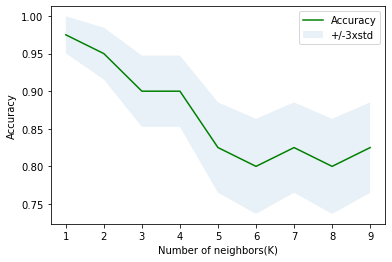

In [11]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc-1*std_acc,mean_acc+1*std_acc,alpha=0.10)
plt.legend(('Accuracy','+/-3xstd'))
plt.ylabel('Accuracy')
plt.xlabel('Number of neighbors(K)')
plt.show()

In [12]:
knn_acc=mean_acc.max()
print('The best accuracy = ',knn_acc,'with K = ',mean_acc.argmax()+1)

The best accuracy =  0.975 with K =  1


# Gaussian Naive Bayes

In [13]:
from sklearn.naive_bayes import GaussianNB

nb=GaussianNB()
nb.fit(X_train,y_train)
pred=nb.predict(X_val)
nb_acc=accuracy_score(pred,y_val)
nb_acc

0.875

# Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression

lr=LogisticRegression(C=0.01,solver='liblinear')
lr.fit(X_train,y_train)
pred=lr.predict(X_val)
lr_acc=accuracy_score(pred,y_val)
lr_acc

0.875

# Decision Tree

In [15]:
from sklearn.tree import DecisionTreeClassifier

model=DecisionTreeClassifier()
parameters=[{'max_depth':[1,2,3,4,5,6,7,8,9,10]}]
clf=GridSearchCV(model,parameters,cv=5,scoring='accuracy')
clf.fit(X_train,y_train)
print(clf.best_params_)

{'max_depth': 4}


**So, max_depth is 4**

In [16]:
clf=DecisionTreeClassifier(criterion='entropy',max_depth=4)
clf.fit(X_train,y_train)
pred=clf.predict(X_val)
tree_acc=accuracy_score(pred,y_val)
tree_acc

1.0

**100% accuracy**

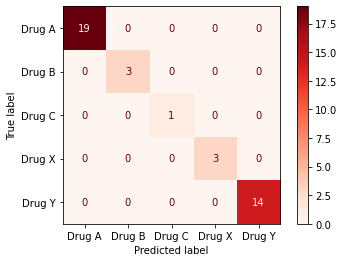

In [17]:
plot_confusion_matrix(clf,X_val,y_val,cmap=plt.cm.Reds,display_labels=['Drug A','Drug B','Drug C','Drug X',
                                                     'Drug Y'])

# Accuracy Scores

In [18]:
scores=pd.DataFrame({
    'Models':['KNearest Neighbors','Gaussian Naive Bayes','Logistic Regression','Decision Tree'],
    'Accuracy':[knn_acc,nb_acc,lr_acc,tree_acc]
})
scores.sort_values(by='Accuracy',ascending=False)

,Models,Accuracy
3,Decision Tree,1.000
0,KNearest Neighbors,0.975
1,Gaussian Naive Bayes,0.875
2,Logistic Regression,0.875


**So, We use Decision Tree Classification Model to predict Drugs with 100% accuracy**

# Visualization

[Text(488.25, 342.46799999999996, 'X[4] <= -0.174\nentropy = 2.008\nsamples = 160\nvalue = [72, 20, 15, 13, 40]'),
 Text(390.6, 266.364, 'X[2] <= -0.5\nentropy = 1.846\nsamples = 88\nvalue = [0, 20, 15, 13, 40]'),
 Text(195.3, 190.26, 'X[0] <= 0.375\nentropy = 0.985\nsamples = 35\nvalue = [0, 20, 15, 0, 0]'),
 Text(97.65, 114.156, 'entropy = 0.0\nsamples = 20\nvalue = [0, 20, 0, 0, 0]'),
 Text(292.95000000000005, 114.156, 'entropy = 0.0\nsamples = 15\nvalue = [0, 0, 15, 0, 0]'),
 Text(585.9000000000001, 190.26, 'X[2] <= 0.72\nentropy = 0.804\nsamples = 53\nvalue = [0, 0, 0, 13, 40]'),
 Text(488.25, 114.156, 'X[3] <= 0.03\nentropy = 1.0\nsamples = 26\nvalue = [0, 0, 0, 13, 13]'),
 Text(390.6, 38.051999999999964, 'entropy = 0.0\nsamples = 13\nvalue = [0, 0, 0, 13, 0]'),
 Text(585.9000000000001, 38.051999999999964, 'entropy = 0.0\nsamples = 13\nvalue = [0, 0, 0, 0, 13]'),
 Text(683.5500000000001, 114.156, 'entropy = 0.0\nsamples = 27\nvalue = [0, 0, 0, 0, 27]'),
 Text(585.9000000000001, 2

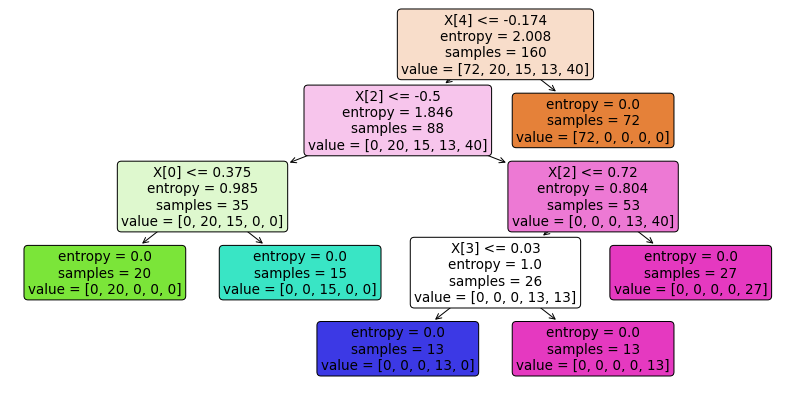

In [19]:
plt.figure(figsize=(14,7))
tree.plot_tree(clf, rounded=True, filled=True)